# Accidents over the time

In the prototyping phase, it was already possible to establish that the `statusId` of a race result contains information about an accident.

**Info:** The `statusId` of a race result indicates how a driver finished the race. In the F1 API, it is also referred to as *‘Finish Status ’*

There are many different `statusId` that need to be analysed in a first phase to find out which IDs declare an accident.
The following list contains all `statusId`, whereby those we have declared as an accident are marked in **bold**:

| ID     | Name           | Beschreibung                                                                 |
|--------|----------------|------------------------------------------------------------------------------|
| 1      | Finished       | Fahrer hat das Rennen regulär beendet                                        |
| 2      | Disqualified   | Fahrer wurde nachträglich disqualifiziert                                    |
| **3**  | **Accident**   | **Ausfall durch Unfall**                                                     |
| **4**  | **Collision**  | **Ausfall durch Kollision mit anderem Fahrer**                               |
| 5      | Engine         | Technischer Ausfall am Motor                                                 |
| 6      | Gearbox        | Ausfall durch Getriebeschaden                                                |
| 7      | Transmission   | Probleme mit dem Antriebsstrang                                              |
| 8      | Clutch         | Kupplungsausfall                                                             |
| 9      | Hydraulics     | Ausfall durch hydraulische Probleme                                          |
| 10     | Electrical     | Elektrikprobleme                                                             |
| 11     | +1 Lap         | Fahrer beendete das Rennen eine Runde hinter dem Sieger                      |
| 12     | +2 Laps        | Zwei Runden Rückstand                                                        |
| 13     | +3 Laps        | Drei Runden Rückstand                                                        |
| 14     | +4 Laps        | Vier Runden Rückstand                                                        |
| 15     | +5 Laps        | Fünf Runden Rückstand                                                        |
| 16     | +6 Laps        | Sechs Runden Rückstand                                                       |
| 17     | +7 Laps        | Sieben Runden Rückstand                                                      |
| 18     | +8 Laps        | Acht Runden Rückstand                                                        |
| 19     | +9 Laps        | Neun Runden Rückstand                                                        |
| **20** | **Spun off**   | **Fahrer verlor Kontrolle und schied durch Dreher aus**                      |
| 21     | Radiator       | Ausfall durch Kühlerprobleme                                                 |
| 22     | Suspension     | Ausfall durch Fahrwerkschaden                                                |
| 23     | Brakes         | Ausfall durch Bremsversagen                                                  |
| 24     | Differential   | Probleme mit dem Differenzial                                                |
| 25     | Overheating    | Ausfall durch Überhitzung                                                    |
| 26     | Mechanical     | Sonstiger mechanischer Defekt                                                |
| 27     | Tyre           | Probleme mit den Reifen (z. B. beschädigt oder falscher Druck)               |
| 28     | Driver Seat    | Problem mit dem Fahrersitz (sehr selten)                                     |
| 29     | Puncture       | Reifenschaden durch Platten                                                  |
| 30     | Driveshaft     | Antriebswelle defekt                                                         |

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, sum, round, when, col, first
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession \
    .builder \
    .appName("F1") \
    .getOrCreate()

25/05/18 17:53:04 WARN Utils: Your hostname, bdlc-004 resolves to a loopback address: 127.0.1.1; using 10.176.129.6 instead (on interface ens192)
25/05/18 17:53:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/18 17:53:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/18 17:53:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/05/18 17:53:05 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/05/18 17:53:05 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
25/05/18 17:53:05 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [3]:
!hdfs dfs -ls /f1/data/cleaned_*.parquet

Found 2 items
-rw-r--r--   2 cluster supergroup          0 2025-04-27 17:08 /f1/data/cleaned_circuits.parquet/_SUCCESS
-rw-r--r--   2 cluster supergroup       6904 2025-04-27 17:08 /f1/data/cleaned_circuits.parquet/part-00000-99e32ab9-9e0f-42b2-a6d3-42d4ef687d18-c000.snappy.parquet
Found 2 items
-rw-r--r--   2 cluster supergroup          0 2025-04-27 17:30 /f1/data/cleaned_constructor_results.parquet/_SUCCESS
-rw-r--r--   2 cluster supergroup      80657 2025-04-27 17:30 /f1/data/cleaned_constructor_results.parquet/part-00000-23998559-62d1-4e57-baa4-d4d192fefdfc-c000.snappy.parquet
Found 2 items
-rw-r--r--   2 cluster supergroup          0 2025-04-27 17:33 /f1/data/cleaned_constructor_standings.parquet/_SUCCESS
-rw-r--r--   2 cluster supergroup     110395 2025-04-27 17:33 /f1/data/cleaned_constructor_standings.parquet/part-00000-a866fd49-8cdf-4567-95b0-47dec9a9f110-c000.snappy.parquet
Found 2 items
-rw-r--r--   2 cluster supergroup          0 2025-04-27 17:34 /f1/data/cleaned_constructo

In [4]:
pit_stops_df = spark.read.parquet(f"/f1/data/cleaned_pit_stops.parquet")
results_df = spark.read.parquet(f"/f1/data/cleaned_results.parquet")
races_df = spark.read.parquet(f"/f1/data/cleaned_races.parquet")
constructors_df = spark.read.parquet(f"/f1/data/cleaned_constructors.parquet")
drivers_df = spark.read.parquet(f"/f1/data/cleaned_drivers.parquet")

In [5]:
pit_stops_df.show(5)
results_df.show(5)
races_df.show(5)
constructors_df.show(5)
drivers_df.show(5)

+------+--------+-------------------+--------+------------+----+---+
|raceId|driverId|               time|duration|milliseconds|stop|lap|
+------+--------+-------------------+--------+------------+----+---+
|   841|     153|2025-04-27 17:05:23|  26.898|       26898|   1|  1|
|   841|      30|2025-04-27 17:05:52|  25.021|       25021|   1|  1|
|   841|      17|2025-04-27 17:20:48|  23.426|       23426|   1| 11|
|   841|       4|2025-04-27 17:22:34|  23.251|       23251|   1| 12|
|   841|      13|2025-04-27 17:24:10|  23.842|       23842|   1| 13|
+------+--------+-------------------+--------+------------+----+---+
only showing top 5 rows

+--------+------+--------+-------------+------+----+--------+------------+-------------+------+----+-----------+------------+----------+----+--------------+---------------+--------+
|resultId|raceId|driverId|constructorId|number|grid|position|positionText|positionOrder|points|laps|       time|milliseconds|fastestLap|rank|fastestLapTime|fastestLapSpeed|

# 1. Has the sport become safer over time?
In this chapter we want to find out how the accidents have developed over the time.

To do this, we first need to select the relevant information. The following steps were taken to do this:

1. Join the races to the results
2. Group the results by the year
3. Aggregate the information
    - count all the results of the year
    - count all the accitens of the year
    - count all accidents that are registered as accident of the year
    - count all accidents that are registered as collisions of the year
    - count all accidents that are registered as spun off of the year
    - calculate the accident rate in relation to all results of this year
4. Sort the list by year

In [6]:
accident_ids = [3, 4, 20]
accidents_per_year_df = results_df.join(
        races_df.select("raceId", "year"),
        on="raceId",
        how="inner"
    ).groupBy("year") \
    .agg(
        count("*").alias("total_results"),
        sum(when(col("statusId").isin(accident_ids), 1).otherwise(0)).alias("total_accident_results"),
        sum(when(col("statusId") == 3, 1).otherwise(0)).alias("accident_results"),
        sum(when(col("statusId") == 4, 1).otherwise(0)).alias("collision_results"),
        sum(when(col("statusId") == 20, 1).otherwise(0)).alias("spun_off_results"),
        round(
            (sum(when(col("statusId").isin(accident_ids), 1).otherwise(0)) / count("*")) * 100, 2
    ).alias("accident_rate")
).orderBy("year")

In [7]:
accidents_per_year_df.show(5)

+----+-------------+----------------------+----------------+-----------------+----------------+-------------+
|year|total_results|total_accident_results|accident_results|collision_results|spun_off_results|accident_rate|
+----+-------------+----------------------+----------------+-----------------+----------------+-------------+
|1950|          160|                    15|              12|                1|               2|         9.38|
|1951|          179|                    10|               9|                0|               1|         5.59|
|1952|          215|                     6|               5|                0|               1|         2.79|
|1953|          246|                    17|              13|                0|               4|         6.91|
|1954|          230|                    18|              13|                0|               5|         7.83|
+----+-------------+----------------------+----------------+-----------------+----------------+-------------+
only showi

## Absolut numbers
Firstly, we look at the years who have had the most accidents in absolute terms.

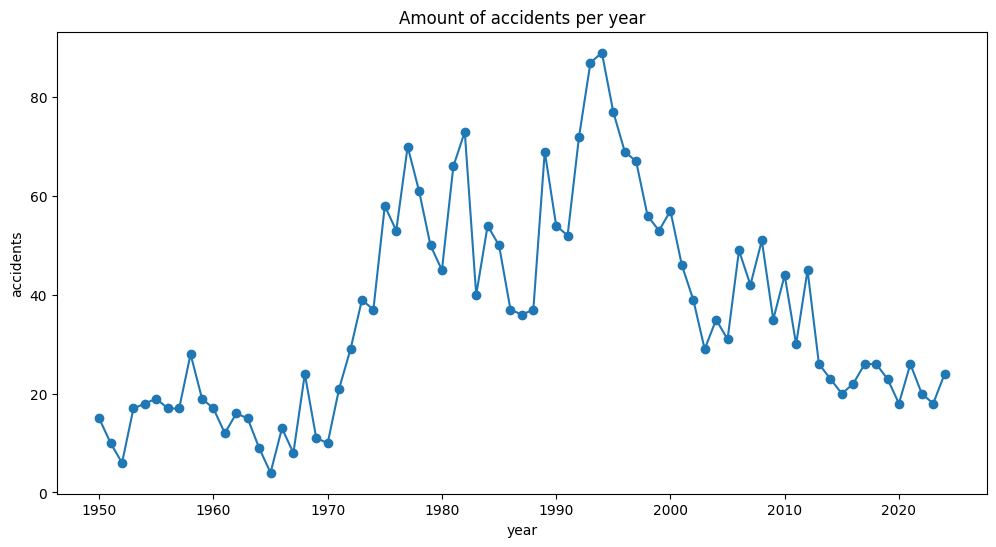

In [8]:
accidents_per_year_df_pd = accidents_per_year_df.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(accidents_per_year_df_pd["year"], accidents_per_year_df_pd["total_accident_results"], marker="o")

plt.title("Amount of accidents per year")
plt.xlabel("year")
plt.ylabel("accidents")

plt.show()

This already gives a first impression of the data. It can be seen that there was an extreme increase between 1970 and 2000.

## Accident rate
In order to the reason in more detail, other factors must also be taken into account.
For that we look at the accident rate for every year.

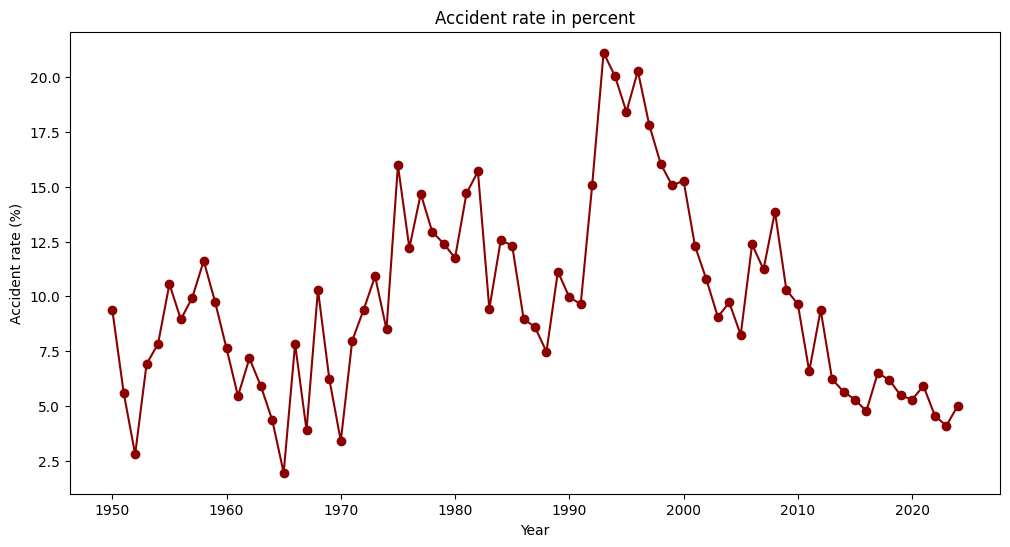

In [9]:
accidents_per_year_df_pd = accidents_per_year_df.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(accidents_per_year_df_pd["year"], accidents_per_year_df_pd["accident_rate"], marker="o", color="darkred")

plt.title("Accident rate in percent")
plt.xlabel("Year")
plt.ylabel("Accident rate (%)")

plt.show()

Now the data looks already a bit different.
There is still an increase in the years 1970 - 2000 but it is way less extreme.

## Differentiation of accident categories
In a next step, we would like to analyse the accident categories.

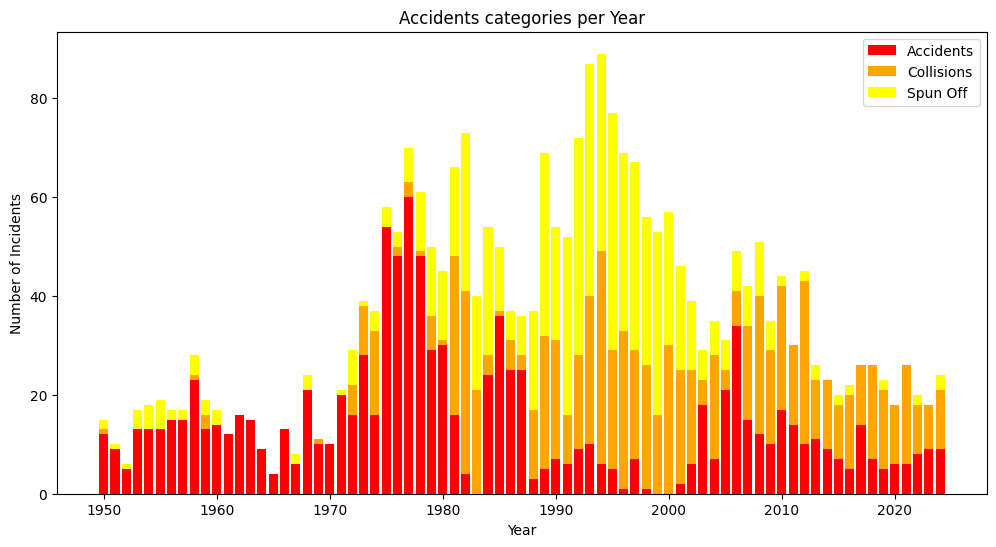

In [10]:
accidents_per_year_df_pd = accidents_per_year_df.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(accidents_per_year_df_pd['year'], accidents_per_year_df_pd['accident_results'], color='red', label='Accidents')
plt.bar(accidents_per_year_df_pd['year'], accidents_per_year_df_pd['collision_results'], bottom=accidents_per_year_df_pd['accident_results'], color='orange', label='Collisions')
plt.bar(accidents_per_year_df_pd['year'], accidents_per_year_df_pd['spun_off_results'], 
        bottom=accidents_per_year_df_pd['accident_results'] + accidents_per_year_df_pd['collision_results'], 
        color='yellow', label='Spun Off')

plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.title('Accidents categories per Year')
plt.legend()

plt.show()

This visualisation reveals even more details of the accidents. It can be seen that the increase in the number of accidents is actually an increase in the number of spun offs and collisions and that the number of accitends (the statusId) has actually fallen.

There could be various reasons for this. For example, there may have been adjustments to the classification, incidents may have been categorised differently. However, we do not have the expertise to explain the exact reasons for this change.

# 2. Which driver had the most accidents?

In this analysis we want to find out which driver had the most accidents.

To do this, we first need to select the relevant information. The following steps were taken to do this:
1. Join the drivers to the results
2. Group the results by the drivers
3. Aggregate the informations
    - forename and surname
    - count all the results of the driver
    - count all the accitens of the driver
    - count all accidents that are registered as accident of the driver
    - count all accidents that are registered as collisions of the driver
    - count all accidents that are registered as spun off of the driver
    - calculate the accident rate in relation to all results of this driver

In [11]:
results_driver_df = results_df.join(
        drivers_df.select("driverId", "forename", "surname"),
        on="driverId",
        how="inner"
    ).groupBy("driverId") \
    .agg(
        first("forename").alias("forename"),
        first("surname").alias("surname"),
        count("*").alias("total_results"),
        sum(when(col("statusId").isin(accident_ids), 1).otherwise(0)).alias("total_accident_results"),
        sum(when(col("statusId") == 3, 1).otherwise(0)).alias("accident_results"),
        sum(when(col("statusId") == 4, 1).otherwise(0)).alias("collision_results"),
        sum(when(col("statusId") == 20, 1).otherwise(0)).alias("spun_off_results"),
        round((sum(when(col("statusId").isin(accident_ids), 1).otherwise(0)) / count("*")) * 100, 2).alias("accident_rate"))

## Absolute numbers
Firstly, we look at the drivers who have had the most accidents in absolute terms.

In [12]:
accident_drivers_absolute_df = results_driver_df.orderBy(
        col("total_accident_results").desc()
    ).select(
        "forename",
        "surname",
        "total_accident_results")

accident_drivers_absolute_df.show(truncate=False, n=20)

+---------+-----------+----------------------+
|forename |surname    |total_accident_results|
+---------+-----------+----------------------+
|Andrea   |de Cesaris |37                    |
|Riccardo |Patrese    |36                    |
|Rubens   |Barrichello|32                    |
|David    |Coulthard  |32                    |
|Johnny   |Herbert    |30                    |
|Michael  |Schumacher |30                    |
|Jean     |Alesi      |30                    |
|Ukyo     |Katayama   |30                    |
|Giancarlo|Fisichella |30                    |
|Pierluigi|Martini    |29                    |
|Jarno    |Trulli     |29                    |
|Nigel    |Mansell    |28                    |
|Nelson   |Piquet     |28                    |
|Eddie    |Irvine     |27                    |
|Ralf     |Schumacher |27                    |
|Gerhard  |Berger     |26                    |
|Derek    |Warwick    |26                    |
|Patrick  |Tambay     |26                    |
|Pedro    |Di

## Accident rate
Then we look at all drivers with he highest accident rate.

In [13]:
drivers_accident_rate_df = results_driver_df.orderBy(
        col("accident_rate").desc(), col("total_results").desc()
    ).select(
        "forename",
        "surname",
        "accident_rate",
        "total_results")

drivers_accident_rate_df.show(truncate=False, n=20)

+--------+----------------+-------------+-------------+
|forename|surname         |accident_rate|total_results|
+--------+----------------+-------------+-------------+
|Roger   |Williamson      |100.0        |2            |
|Stéphane|Sarrazin        |100.0        |1            |
|Marco   |Apicella        |100.0        |1            |
|Dave    |Morgan          |100.0        |1            |
|Ben     |Pon             |100.0        |1            |
|Wayne   |Weiler          |100.0        |1            |
|Arthur  |Owen            |100.0        |1            |
|Bob     |Said            |100.0        |1            |
|Jerry   |Unser           |100.0        |1            |
|Art     |Bisch           |100.0        |1            |
|François|Picard          |100.0        |1            |
|Tom     |Bridger         |100.0        |1            |
|Don     |Edmunds         |100.0        |1            |
|Elmer   |George          |100.0        |1            |
|Colin   |Chapman         |100.0        |1      

As you can see, there were many drivers who only competed in one race and had an accident in that race.

**Info**: An interesting sight is Roger Williamson, who had an accident in his first two races and unfortunately died in the second

For a more exciting result, we set the minimum number of races to 20 in a second step

In [14]:
drivers_accident_rate_20_races_df = drivers_accident_rate_df.filter(
        col("total_results") >= 20
    ).show(
        truncate=False,
        n=20)

+------------+----------+-------------+-------------+
|forename    |surname   |accident_rate|total_results|
+------------+----------+-------------+-------------+
|Ukyo        |Katayama  |30.93        |97           |
|Ian         |Scheckter |30.0         |20           |
|Mark        |Blundell  |28.57        |63           |
|Nelson      |Piquet Jr.|28.57        |28           |
|Pedro       |Diniz     |25.25        |99           |
|Satoru      |Nakajima  |25.0         |80           |
|Antônio     |Pizzonia  |25.0         |20           |
|François    |Hesnault  |25.0         |20           |
|Hans-Joachim|Stuck     |24.69        |81           |
|Rupert      |Keegan    |24.32        |37           |
|Jan         |Magnussen |24.0         |25           |
|Tom         |Pryce     |23.81        |42           |
|Pierluigi   |Martini   |23.58        |123          |
|Ricardo     |Rosset    |23.33        |30           |
|Bruno       |Giacomelli|21.95        |82           |
|Pedro       |Lamy      |21.

Now the table is a lot more meaningful, as all the drivers have contested a few races.

## Differentiation of accident categories
The last thing we look at is the different categories.

For that we look at the drivers with the highest accident rate and at least 20 races.

In [15]:
drivers_accident_rate_20_races_df = results_driver_df.filter(
        col("total_results") >= 20
    ).orderBy(
        col("accident_rate").desc(), col("total_results").desc())

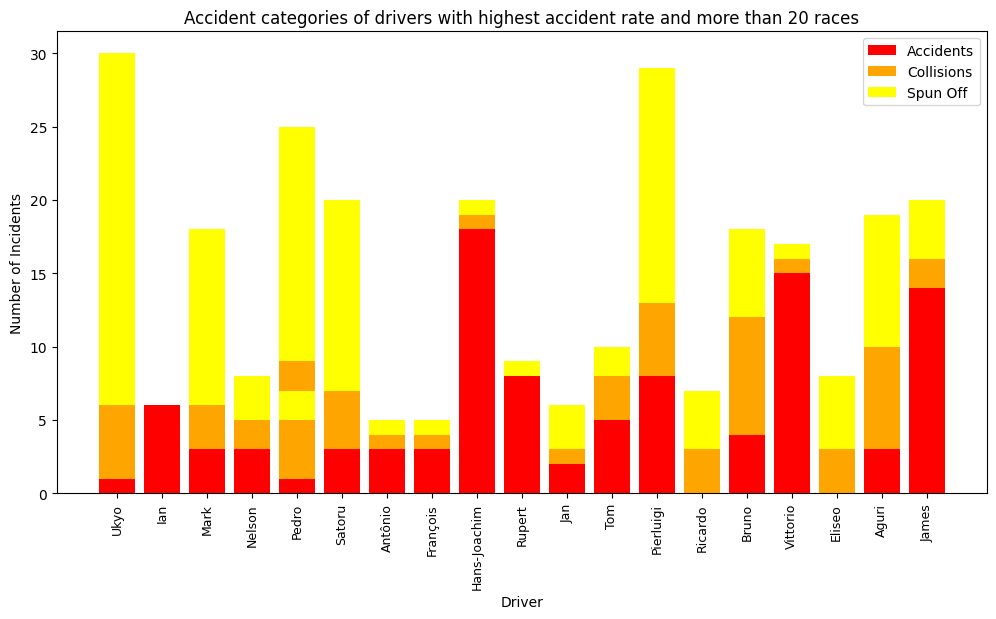

In [16]:
drivers_accident_rate_20_races_df_pd = drivers_accident_rate_20_races_df.limit(20).toPandas()

# gestapelte Balken zeichnen
plt.figure(figsize=(12, 6))
plt.bar(drivers_accident_rate_20_races_df_pd['forename'], drivers_accident_rate_20_races_df_pd['accident_results'], color='red', label='Accidents')
plt.bar(drivers_accident_rate_20_races_df_pd['forename'], drivers_accident_rate_20_races_df_pd['collision_results'], bottom=drivers_accident_rate_20_races_df_pd['accident_results'], color='orange', label='Collisions')
plt.bar(drivers_accident_rate_20_races_df_pd['forename'], drivers_accident_rate_20_races_df_pd['spun_off_results'], 
        bottom=drivers_accident_rate_20_races_df_pd['accident_results'] + drivers_accident_rate_20_races_df_pd['collision_results'], 
        color='yellow', label='Spun Off')

# Achsentitel und Legende
plt.xlabel('Driver')
plt.ylabel('Number of Incidents')
plt.title('Accident categories of drivers with highest accident rate and more than 20 races')
plt.legend()
plt.xticks(rotation=90, fontsize=9)

plt.show()

# 3. Which team had the most accidents?
In this analysis we want to find out which team had the most accidents.

To do this, we first need to select the relevant information. The following steps were taken to do this:
1. Join the constructors (teams) to the results
2. Group the results by the teams
3. Aggregate the informations
    - team name
    - count all the results of the team
    - count all the accitens of the team
    - count all accidents that are registered as accident of the team
    - count all accidents that are registered as collisions of the team
    - count all accidents that are registered as spun off of the team
    - calculate the accident rate in relation to all results of this team

In [17]:
results_constructors_df = results_df.join(
        constructors_df.select("constructorId", "name"),
        on="constructorId",
        how="inner"
    ).groupBy("constructorId") \
    .agg(
        first("name").alias("name"),
        count("*").alias("total_results"),
        sum(when(col("statusId").isin(accident_ids), 1).otherwise(0)).alias("total_accident_results"),
        sum(when(col("statusId") == 3, 1).otherwise(0)).alias("accident_results"),
        sum(when(col("statusId") == 4, 1).otherwise(0)).alias("collision_results"),
        sum(when(col("statusId") == 20, 1).otherwise(0)).alias("spun_off_results"),
        round((sum(when(col("statusId").isin(accident_ids), 1).otherwise(0)) / count("*")) * 100, 2).alias("accident_rate"))

## Absolute numbers
Again first we look at the teams who have had the most accidents in absolute terms.

In [18]:
top_accident_teams_absolute_df = results_constructors_df.orderBy(
        col("total_accident_results").desc()
    ).select(
        "name",
        "total_accident_results")

top_accident_teams_absolute_df.show(truncate=False, n=20)

+-----------+----------------------+
|name       |total_accident_results|
+-----------+----------------------+
|Ferrari    |198                   |
|McLaren    |181                   |
|Williams   |176                   |
|Tyrrell    |137                   |
|Sauber     |114                   |
|Minardi    |109                   |
|Team Lotus |107                   |
|Ligier     |91                    |
|Jordan     |87                    |
|Renault    |84                    |
|Arrows     |79                    |
|Benetton   |72                    |
|Brabham    |68                    |
|March      |59                    |
|Toro Rosso |54                    |
|Alfa Romeo |50                    |
|Force India|49                    |
|Red Bull   |49                    |
|BRM        |43                    |
|Footwork   |40                    |
+-----------+----------------------+
only showing top 20 rows



## Accident rate
Then we look at the teams with he highest accident rate.

In [19]:
teams_accident_rate_df = results_constructors_df.orderBy(
        col("accident_rate").desc(), col("total_results").desc()
    ).select(
        "name",
        "accident_rate",
        "total_results")

teams_accident_rate_df.show(truncate=False, n=20)

+-------------------------+-------------+-------------+
|name                     |accident_rate|total_results|
+-------------------------+-------------+-------------+
|Elder                    |100.0        |1            |
|Politoys                 |100.0        |1            |
|Sutton                   |100.0        |1            |
|Olson                    |100.0        |1            |
|Dunn                     |66.67        |3            |
|Lyncar                   |50.0         |2            |
|LDS-Climax               |50.0         |2            |
|Lancia                   |36.36        |11           |
|Kojima                   |33.33        |3            |
|Lotus-Pratt &amp; Whitney|33.33        |3            |
|Shadow-Ford              |30.77        |26           |
|Embassy Hill             |26.32        |19           |
|Trojan                   |25.0         |8            |
|Deidt                    |25.0         |8            |
|Token                    |25.0         |4      

Here again we have the problem with teams that have only taken part in a few races.

We therefore only filter for teams that have achieved at least 100 results.

In [20]:
teams_accident_rate_df.filter(
        col("total_results") >= 100
    ).show(
        truncate=False,
        n=20)

+------------+-------------+-------------+
|name        |accident_rate|total_results|
+------------+-------------+-------------+
|Footwork    |20.62        |194          |
|Jordan      |17.4         |500          |
|Kurtis Kraft|16.81        |226          |
|Minardi     |16.22        |672          |
|Jaguar      |15.88        |170          |
|Tyrrell     |15.55        |881          |
|Ligier      |14.89        |611          |
|Prost       |14.55        |165          |
|Shadow      |14.22        |211          |
|Dallara     |13.89        |144          |
|Benetton    |13.85        |520          |
|Surtees     |13.85        |260          |
|Sauber      |13.62        |837          |
|ATS         |13.58        |162          |
|Arrows      |13.39        |590          |
|Larrousse   |12.5         |216          |
|Team Lotus  |12.28        |871          |
|Force India |11.56        |424          |
|March       |11.26        |524          |
|Alfa Romeo  |11.09        |451          |
+----------

Many of the current teams that we have seen in the table of absolute numbers have disappeared here because they have had a lot of accidents, because they have been in Formula 1 for a long time.

## Accident rate of current teams
As a final analysis, let's take a look at the accident rates of the current teams.

In [21]:
current_teams = [
    "Red Bull", "Mercedes", "Ferrari", "McLaren", "Aston Martin", "Alpine F1 Team",
    "RB F1 Team", "AlphaTauri", "Sauber", "Alfa Romeo", "Haas F1 Team", "Williams"
]

teams_accident_rate_df.filter(
        (col("total_results") >= 100) & (col("name").isin(current_teams))
    ).show(
        truncate=False,
        n=20)

+--------------+-------------+-------------+
|name          |accident_rate|total_results|
+--------------+-------------+-------------+
|Sauber        |13.62        |837          |
|Alfa Romeo    |11.09        |451          |
|Williams      |10.5         |1676         |
|McLaren       |9.41         |1923         |
|Ferrari       |8.12         |2439         |
|Haas F1 Team  |6.84         |380          |
|Red Bull      |6.22         |788          |
|AlphaTauri    |5.42         |166          |
|Aston Martin  |4.19         |191          |
|Mercedes      |4.14         |652          |
|Alpine F1 Team|2.78         |180          |
+--------------+-------------+-------------+

